In [1]:
f_path = '/home/u/u241308/script_python/gb_functions'
import sys
sys.path.insert(1, f_path)
import gb_hwdetect_optimized as gb_hw

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import xarray as xr
import copy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from math import sin, cos, sqrt, atan2, radians

In [2]:
#reference time
ref_min = 1985
ref_max = 2014

# Consecutive days for heatwave detection
c_days = 6

# Threshold percentile
percentile = 90 #95

#Definition type: daily moving threshold (mov_day) or JA moving threshold (mov_JA)
def_type = 'fix_day' #'mov_JA'

In [3]:
#load t2max
path = '/work/uo1075/u241308/reanalysis/eobs/eobs_hw_projections/'
file = 'tasmax_1950_2022_GEgrid2_anomaly_detrended_multi_model.nc'
with xr.open_dataset(path+file) as data1:
    #data1 = data1.rename({'__xarray_dataarray_variable__':'tx'})
    data1 = data1.tx
    
    #Get rid off 29th of februarys
    data1 = data1.sel(time=~((data1.time.dt.month == 2) & (data1.time.dt.day == 29)))
    
#load threshold
path = '/work/uo1075/u241308/data_python/HW_extension/eobs/'
file = 'threshold_%s'%percentile+ '_fix_day_eobs_ref_%i'%ref_min + '-%i_anomaly_detrended_multi_model.nc'%ref_max  
with xr.open_dataset(path+file) as threshold:
    threshold = threshold.tx
    
    #select one year (all years are the same in fix_day)
    threshold = threshold[(threshold.time.dt.year==threshold.time.dt.year.min())].values
    
    #expand threhsold to dimensions of data1
    year_number = np.unique(data1.time.dt.year).shape[0]
    threshold_complete = copy.deepcopy(data1)
    threshold_complete[:,:,:] = np.tile(threshold,(year_number,1,1))
    
#load hw_detect
path = '/work/uo1075/u241308/data_python/HW_extension/eobs/'
file = 'hw_detect_%id'%c_days +'_%s'%percentile+ '_' + def_type + '_eobs_ref_%i'%ref_min + '-%i_anomaly_detrended_multi_model.nc'%ref_max    
with xr.open_dataset(path+file) as hw_detect:
    hw_detect = hw_detect.tx

In [4]:
data_exceed = data1 - threshold_complete
data_exceed = xr.where(hw_detect==1,data_exceed,0)

In [5]:
#longitude weight: cosine of the latitude
grid_weight2 = np.zeros((len(data1.lat),len(data1.lon)))
for y in range(0,len(data1.lat)):
    grid_weight2[y,:] = cos(radians(data1.lat[y]))
    
grid_weight2 = np.repeat(grid_weight2[np.newaxis,:,:],data_exceed.shape[0],axis=0)

In [6]:
#weight the grid exceedance
data_exceed_weighted = copy.deepcopy(data_exceed)
data_exceed_weighted[:,:,:] = np.multiply(data_exceed,grid_weight2)

In [7]:
#EOBS has already correct longitude grids, lines below not neccessary

##Define new longitudes: from 0,360 to -180,180
#data_exceed_weighted['lon'] = np.where(data_exceed_weighted.lon >180, data_exceed_weighted.lon-360,data_exceed_weighted.lon)
#ind = np.argsort(data_exceed_weighted.lon)
#ind.values
#data_exceed_weighted = data_exceed_weighted[:,:,ind.values]

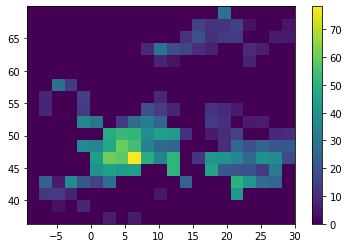

In [8]:
year_sel = 2003
joker = data_exceed_weighted.resample(time='y').sum()
joker = joker[joker.time.dt.year==year_sel,:,:]
plt.pcolormesh(data_exceed_weighted.lon,data_exceed_weighted.lat,joker[0,:,:])
plt.colorbar()

In [9]:
#save data
path = '/work/uo1075/u241308/data_python/HW_extension/eobs/'
file = 'data_exceed_lonlat_weighted_%s' %percentile + 'pct_%s' %c_days + 'd_' + def_type + '_eobs_ref_%i'%ref_min + '-%i_anomaly_detrended_multi_model.nc'%ref_max  
data_exceed_weighted.to_netcdf(path+file)